In [1]:
!which python 

/opt/anaconda3/envs/spiketurnpike_postanalysis/bin/python


In [2]:
!pip show pyabf

Name: pyabf
Version: 2.3.8
Summary: Python library for reading files in Axon Binary Format (ABF)
Home-page: http://swharden.com/pyabf
Author: Scott W Harden
Author-email: SWHarden@gmail.com
License: MIT License
Location: /opt/anaconda3/envs/spiketurnpike_postanalysis/lib/python3.9/site-packages
Requires: matplotlib, numpy, pytest
Required-by: 


In [12]:
from spiketurnpike_postanalysis.Extract_patch_data_from_abf import PatchDataExtractor
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import re  # Import the re module for regular expressions
from matplotlib.backends.backend_pdf import PdfPages
import pyabf
from scipy.signal import find_peaks

In [ ]:
class BladePatchDataProcessor:
    def __init__(self, base_path):
        """
        Initialize the BladePatchDataProcessor with the base path.

        Args:
            base_path (str): Path to the BLADe_patch_data folder.
        """
        self.base_path = base_path  # Base directory path
        self.dataframe = None  # DataFrame to store metadata
        self.unique_groups = None  # List of unique group names

    def process_data(self):
        """
        Process the BLADe_patch_data folder to extract metadata about .abf files.

        This method populates the `dataframe` and `unique_groups` attributes.
        """
        data = []

        # Walk through each group in the base path
        for group_dir in os.listdir(self.base_path):
            group_path = os.path.join(self.base_path, group_dir)
            if not os.path.isdir(group_path):
                continue  # Skip non-directory files

            # Determine linking pattern based on the group
            if group_dir == "L + CS-Veh":
                identifier_pattern = r"Veh-\d+"
            else:
                identifier_pattern = r"CTZ-\d+"

            # Look for .abf files in the group directory
            for file_name in os.listdir(group_path):
                if file_name.endswith(".abf"):
                    # Parse the label ("Before" or "After")
                    if "Before" in file_name:
                        label = "Before"
                    elif "After" in file_name:
                        label = "After"
                    else:
                        continue  # Skip files without "Before" or "After"

                    # Extract linking identifier (e.g., "CTZ-1", "Veh-2")
                    match = re.search(identifier_pattern, file_name)
                    if not match:
                        print(f"Warning: No linking identifier found in file {file_name}. Skipping.")
                        continue
                    recording_id = match.group(0)

                    # Append metadata to the list
                    data.append({
                        "Group": group_dir,
                        "Recording_ID": recording_id,
                        "Label": label,
                        "File_Path": os.path.join(group_path, file_name)
                    })

        # Convert the list of metadata to a DataFrame
        self.dataframe = pd.DataFrame(data)

        # Sort the DataFrame by Group and Recording ID for clarity
        if not self.dataframe.empty:
            self.dataframe = self.dataframe.sort_values(by=["Group", "Recording_ID", "Label"]).reset_index(drop=True)
            # Extract unique group names
            self.unique_groups = self.dataframe["Group"].unique().tolist()
        else:
            self.unique_groups = []

    def get_summary(self):
        """
        Get a summary of the processed data.

        Returns:
            str: A summary string including number of groups and recordings.
        """
        if self.dataframe is None:
            return "No data processed yet."

        summary = (
            f"Total Groups: {len(self.unique_groups)}\n"
            f"Unique Groups: {self.unique_groups}\n"
            f"Total Recordings: {len(self.dataframe)}"
        )
        return summary
    
    def plot_sweeps_pdf(self, output_dir):
        """
        Generate a multipage PDF for each group, with each page containing Before and After sweeps.

        Args:
            output_dir (str): Path to save the generated PDF files.
        """
        if self.dataframe is None or self.dataframe.empty:
            print("No data to plot. Run `process_data` first.")
            return

        os.makedirs(output_dir, exist_ok=True)

        # Group by unique groups
        for group in self.unique_groups:
            group_data = self.dataframe[self.dataframe["Group"] == group]
            pdf_path = os.path.join(output_dir, f"{group}.pdf")
            saved_pages = 0  # Track the number of pages added to the PDF

            # Determine linking pattern based on the group
            if group == "L + CS-Veh":
                identifier_pattern = "Veh"
            else:
                identifier_pattern = "CTZ"

            # Extract unique linking pairs
            linking_ids = group_data["Recording_ID"].str.extract(f"({identifier_pattern}-\d+)")[0].dropna().unique()

            with PdfPages(pdf_path) as pdf:
                for link_id in linking_ids:
                    # Filter "Before" and "After" files for the current linking pair
                    before_file = group_data[(group_data["Recording_ID"].str.contains(link_id)) & (group_data["Label"] == "Before")]["File_Path"]
                    after_file = group_data[(group_data["Recording_ID"].str.contains(link_id)) & (group_data["Label"] == "After")]["File_Path"]

                    if before_file.empty or after_file.empty:
                        print(f"Skipping incomplete pair for Link ID: {link_id} in group {group}")
                        continue  # Skip if "Before" or "After" is missing

                    before_file = before_file.iloc[0]
                    after_file = after_file.iloc[0]

                    # Create the figure with 1x2 layout
                    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
                    fig.suptitle(f"Group: {group}, Link ID: {link_id}", fontsize=14)

                    # Plot Before
                    abf_before = pyabf.ABF(before_file)
                    for sweepNumber in abf_before.sweepList:
                        abf_before.setSweep(sweepNumber)
                        offset = 140 * sweepNumber
                        axes[0].plot(abf_before.sweepX, abf_before.sweepY + offset, color='C0')
                    axes[0].set_title("Before")
                    axes[0].get_yaxis().set_visible(False)
                    axes[0].set_xlabel(abf_before.sweepLabelX)

                    # Plot After
                    abf_after = pyabf.ABF(after_file)
                    for sweepNumber in abf_after.sweepList:
                        abf_after.setSweep(sweepNumber)
                        offset = 140 * sweepNumber
                        axes[1].plot(abf_after.sweepX, abf_after.sweepY + offset, color='C1')
                    axes[1].set_title("After")
                    axes[1].get_yaxis().set_visible(False)
                    axes[1].set_xlabel(abf_after.sweepLabelX)

                    # Save the current figure to the PDF
                    pdf.savefig(fig)
                    plt.close(fig)
                    saved_pages += 1

                if saved_pages == 0:
                    print(f"No valid data to plot for group '{group}'. Deleting empty PDF.")
                    os.remove(pdf_path)
                else:
                    print(f"Saved PDF for group '{group}' to: {pdf_path}")              

    def detect_action_potentials(self, group, recording_id, label, sweep_number, height=None, prominence=None, distance=None, width=None):
            """
            Detect and plot action potentials (APs) for a specific recording from the DataFrame.

            Args:
                group (str): The group name.
                recording_id (str): The recording ID (e.g., "CTZ-1").
                label (str): The label ("Before" or "After").
                sweep_number (int): Sweep number to analyze.
                height (float, optional): Minimum height of peaks (APs) to detect.
                prominence (float, optional): Minimum prominence of peaks (APs) to detect.
                distance (float, optional): Minimum distance between consecutive peaks.
                width (float, optional): Minimum width of peaks.

            Returns:
                dict: A dictionary with sweep number, detected AP count, and peak indices.
            """
            # Locate the file path from the DataFrame
            entry = self.dataframe[
                (self.dataframe["Group"] == group) &
                (self.dataframe["Recording_ID"] == recording_id) &
                (self.dataframe["Label"] == label)
            ]

            if entry.empty:
                raise ValueError(f"No entry found for Group: {group}, Recording ID: {recording_id}, Label: {label}")

            file_path = entry["File_Path"].iloc[0]

            # Load the ABF file
            abf = pyabf.ABF(file_path)
            abf.setSweep(sweepNumber=sweep_number)

            # Extract time (X-axis) and voltage (Y-axis) data
            time = abf.sweepX
            voltage = abf.sweepY

            # Detect peaks using scipy's find_peaks
            peaks, properties = find_peaks(
                voltage,
                height=height,
                prominence=prominence,
                distance=distance,
                width=width
            )

            # Count the number of action potentials (peaks)
            ap_count = len(peaks)

            # Plot the sweep with peaks overlaid
            plt.figure(figsize=(10, 6))
            plt.plot(time, voltage, label="Voltage Trace", color="C0")
            plt.plot(time[peaks], voltage[peaks], "x", label="Detected Peaks", color="C3")
            plt.title(f"Group: {group}, Recording ID: {recording_id}, Sweep {sweep_number}: Detected {ap_count} Action Potentials")
            plt.xlabel("Time (s)")
            plt.ylabel("Voltage (mV)")
            plt.legend()
            plt.show()

            # Return a summary of results
            return {
                "group": group,
                "recording_id": recording_id,
                "label": label,
                "sweep_number": sweep_number,
                "action_potential_count": ap_count,
                "peak_indices": peaks
            }
            
    def create_group_pdf_with_peaks(self, output_dir, height=None, prominence=None, distance=None, width=None):
        """
        Generate a 2x1 multipage PDF for each group. Each page contains "Before" and "After"
        sweeps of a single recording with action potential peaks annotated.

        Args:
            output_dir (str): Path to save the generated PDF files.
            height (float, optional): Minimum height of peaks (APs) to detect.
            prominence (float, optional): Minimum prominence of peaks (APs) to detect.
            distance (float, optional): Minimum distance between consecutive peaks.
            width (float, optional): Minimum width of peaks.
        """
        if self.dataframe is None or self.dataframe.empty:
            print("No data to plot. Run `process_data` first.")
            return

        os.makedirs(output_dir, exist_ok=True)

        for group in self.unique_groups:
            group_data = self.dataframe[self.dataframe["Group"] == group]
            pdf_path = os.path.join(output_dir, f"{group}_wide.pdf")

            with PdfPages(pdf_path) as pdf:
                # Get unique recording IDs for the group
                recording_ids = group_data["Recording_ID"].unique()

                for recording_id in recording_ids:
                    # Locate Before and After entries
                    before_entry = group_data[(group_data["Recording_ID"] == recording_id) & (group_data["Label"] == "Before")]
                    after_entry = group_data[(group_data["Recording_ID"] == recording_id) & (group_data["Label"] == "After")]

                    if before_entry.empty or after_entry.empty:
                        print(f"Skipping incomplete pair for Recording ID: {recording_id} in group {group}")
                        continue

                    # Load Before and After ABF files
                    before_file = before_entry["File_Path"].iloc[0]
                    after_file = after_entry["File_Path"].iloc[0]
                    before_abf = pyabf.ABF(before_file)
                    after_abf = pyabf.ABF(after_file)

                    # Create a 2x1 figure for the recording
                    fig, axes = plt.subplots(2, 1, figsize=(16, 12), sharex=True)
                    fig.suptitle(f"Group: {group}, Recording ID: {recording_id}", fontsize=16)

                    # Plot Before sweeps (Top Panel)
                    before_peak_counts = []
                    for sweep_number in before_abf.sweepList:
                        before_abf.setSweep(sweepNumber=sweep_number)
                        time = before_abf.sweepX
                        voltage = before_abf.sweepY

                        # Detect peaks
                        peaks, properties = find_peaks(
                            voltage,
                            height=height,
                            prominence=prominence,
                            distance=distance,
                            width=width
                        )

                        # Count peaks and store for annotation
                        before_peak_counts.append(len(peaks))

                        # Plot the sweep with peaks
                        offset = 140 * sweep_number  # Offset to stack sweeps visually
                        axes[0].plot(time, voltage + offset, label=f"Sweep {sweep_number}", color="C0")
                        axes[0].plot(time[peaks], voltage[peaks] + offset, "x", color="C3")

                        # Annotate number of peaks and sweep number for Before sweeps
                        for sweep_number, peak_count in enumerate(before_peak_counts):
                            axes[0].text(
                                -0.05,  # Slightly to the left of the x-axis start
                                140 * sweep_number,  # Same vertical position as the trace
                                f"Sweep {sweep_number}: {peak_count} APs",  # Add sweep number and AP count
                                fontsize=10,
                                color="C0",
                                ha="right"  # Align text to the right
                            )

                    axes[0].set_title("Before")
                    axes[0].get_yaxis().set_visible(False)

                    # Plot After sweeps (Bottom Panel)
                    after_peak_counts = []
                    for sweep_number in after_abf.sweepList:
                        after_abf.setSweep(sweepNumber=sweep_number)
                        time = after_abf.sweepX
                        voltage = after_abf.sweepY

                        # Detect peaks
                        peaks, properties = find_peaks(
                            voltage,
                            height=height,
                            prominence=prominence,
                            distance=distance,
                            width=width
                        )

                        # Count peaks and store for annotation
                        after_peak_counts.append(len(peaks))

                        # Plot the sweep with peaks
                        offset = 140 * sweep_number  # Offset to stack sweeps visually
                        axes[1].plot(time, voltage + offset, label=f"Sweep {sweep_number}", color="C1")
                        axes[1].plot(time[peaks], voltage[peaks] + offset, "x", color="C4")
                        
                        # Annotate number of peaks and sweep number for After sweeps
                        for sweep_number, peak_count in enumerate(after_peak_counts):
                            axes[1].text(
                                -0.05,  # Slightly to the left of the x-axis start
                                140 * sweep_number,  # Same vertical position as the trace
                                f"Sweep {sweep_number}: {peak_count} APs",  # Add sweep number and AP count
                                fontsize=10,
                                color="C1",
                                ha="right"  # Align text to the right
                            )
                    axes[1].set_title("After")
                    axes[1].get_yaxis().set_visible(False)

                    # Decorate the figure
                    axes[1].set_xlabel("Time (s)")
                    for ax in axes:
                        ax.set_ylabel("Voltage (mV)")
                        ax.legend(loc="upper right")

                    # Save the current page to the PDF
                    pdf.savefig(fig)
                    plt.close(fig)

            print(f"Saved wide PDF for group '{group}' to: {pdf_path}")
            
    def process_peaks(self, height=None, prominence=None, distance=None, width=None, save_csv_path=None):
        """
        Process all recordings to detect action potentials (peaks) for each sweep
        and optionally save the results to a CSV file.

        Args:
            height (float, optional): Minimum height of peaks (APs) to detect.
            prominence (float, optional): Minimum prominence of peaks (APs) to detect.
            distance (float, optional): Minimum distance between consecutive peaks.
            width (float, optional): Minimum width of peaks.
            save_csv_path (str, optional): Path to save the processed peaks data as a CSV file.

        Returns:
            None: Stores the results in self.peak_dataframe and optionally saves it as a CSV.
        """
        if self.dataframe is None or self.dataframe.empty:
            print("No data to process. Run `process_data` first.")
            return

        peak_data = []

        for group in self.unique_groups:
            group_data = self.dataframe[self.dataframe["Group"] == group]

            for _, row in group_data.iterrows():
                recording_id = row["Recording_ID"]
                label = row["Label"]
                file_path = row["File_Path"]

                # Load the ABF file
                abf = pyabf.ABF(file_path)

                for sweep_number in abf.sweepList:
                    abf.setSweep(sweepNumber=sweep_number)
                    voltage = abf.sweepY

                    # Detect peaks
                    peaks, _ = find_peaks(
                        voltage,
                        height=height,
                        prominence=prominence,
                        distance=distance,
                        width=width
                    )

                    # Append results to the list
                    peak_data.append({
                        "Group": group,
                        "Recording_ID": recording_id,
                        "Label": label,
                        "Sweep_Number": sweep_number,
                        "AP_Count": len(peaks)
                    })

        # Create a DataFrame from the results
        self.peak_dataframe = pd.DataFrame(peak_data)
        print(f"Processed peaks for {len(self.peak_dataframe)} sweeps.")

        # Save to CSV if path is provided
        if save_csv_path:
            self.peak_dataframe.to_csv(save_csv_path, index=False)
            print(f"Saved peak data to {save_csv_path}.")
                     
    def import_csv_and_plot_mean_peaks(self, csv_path, output_pdf_path):
        """
        Import a CSV file containing peak data and plot the mean AP counts
        for "Before" and "After" sweeps for each group.

        Args:
            csv_path (str): Path to the CSV file containing peak data.
            output_pdf_path (str): Path to save the output PDF.

        Returns:
            None
        """
        # Load the CSV into a DataFrame
        try:
            peak_data = pd.read_csv(csv_path)
        except FileNotFoundError:
            print(f"File not found: {csv_path}")
            return

        # Validate the required columns
        required_columns = ["Group", "Recording_ID", "Label", "Sweep_Number", "AP_Count"]
        if not all(col in peak_data.columns for col in required_columns):
            print("The CSV file is missing one or more required columns.")
            return

        # Ensure the output directory exists
        os.makedirs(os.path.dirname(output_pdf_path), exist_ok=True)

        # Open a PDF for plotting
        with PdfPages(output_pdf_path) as pdf:
            # Group by "Group" and compute means
            groups = peak_data["Group"].unique()
            for group in groups:
                group_data = peak_data[peak_data["Group"] == group]

                # Compute mean and SEM for Before and After
                before_data = group_data[group_data["Label"] == "Before"]
                after_data = group_data[group_data["Label"] == "After"]

                mean_before = before_data.groupby("Recording_ID")["AP_Count"].mean()
                mean_after = after_data.groupby("Recording_ID")["AP_Count"].mean()

                sem_before = before_data.groupby("Recording_ID")["AP_Count"].sem()
                sem_after = after_data.groupby("Recording_ID")["AP_Count"].sem()

                # Plot the data
                fig, ax = plt.subplots(figsize=(10, 6))
                ax.bar(
                    x=["Before", "After"],
                    height=[mean_before.mean(), mean_after.mean()],
                    yerr=[sem_before.mean(), sem_after.mean()],
                    capsize=5,
                    color=["C0", "C1"],
                    alpha=0.7,
                    label=["Before", "After"]
                )
                ax.set_title(f"Group: {group}", fontsize=14)
                ax.set_ylabel("Mean AP Count (± SEM)")
                ax.set_xlabel("Condition")
                ax.legend()

                # Save the page to the PDF
                pdf.savefig(fig)
                plt.close(fig)

        print(f"Saved mean AP count plots to: {output_pdf_path}")
     
    def import_csv_and_plot_mean_peaks_lineplot(self, csv_path, output_pdf_path):
        """
        Import a CSV file containing peak data and plot the mean AP counts
        as a function of sweep number for each group.

        Args:
            csv_path (str): Path to the CSV file containing peak data.
            output_pdf_path (str): Path to save the output PDF.

        Returns:
            None
        """
        # Load the CSV into a DataFrame
        try:
            peak_data = pd.read_csv(csv_path)
        except FileNotFoundError:
            print(f"File not found: {csv_path}")
            return

        # Validate the required columns
        required_columns = ["Group", "Recording_ID", "Label", "Sweep_Number", "AP_Count"]
        if not all(col in peak_data.columns for col in required_columns):
            print("The CSV file is missing one or more required columns.")
            return

        # Ensure the output directory exists
        os.makedirs(os.path.dirname(output_pdf_path), exist_ok=True)

        # Open a PDF for plotting
        with PdfPages(output_pdf_path) as pdf:
            # Get unique groups
            groups = peak_data["Group"].unique()
            for group in groups:
                group_data = peak_data[peak_data["Group"] == group]

                # Compute mean and SEM for "Before" and "After" by Sweep_Number
                before_data = group_data[group_data["Label"] == "Before"]
                after_data = group_data[group_data["Label"] == "After"]

                mean_before = before_data.groupby("Sweep_Number")["AP_Count"].mean()
                sem_before = before_data.groupby("Sweep_Number")["AP_Count"].sem()

                mean_after = after_data.groupby("Sweep_Number")["AP_Count"].mean()
                sem_after = after_data.groupby("Sweep_Number")["AP_Count"].sem()

                # Plot the data
                fig, ax = plt.subplots(figsize=(10, 6))
                sweep_numbers = mean_before.index

                # Plot "Before" with SEM
                ax.plot(
                    sweep_numbers, mean_before,
                    label="Before",
                    color="C0",
                    linewidth=2
                )
                ax.fill_between(
                    sweep_numbers,
                    mean_before - sem_before,
                    mean_before + sem_before,
                    color="C0",
                    alpha=0.3
                )

                # Plot "After" with SEM
                ax.plot(
                    sweep_numbers, mean_after,
                    label="After",
                    color="C1",
                    linewidth=2
                )
                ax.fill_between(
                    sweep_numbers,
                    mean_after - sem_after,
                    mean_after + sem_after,
                    color="C1",
                    alpha=0.3
                )

                # Decorate the plot
                ax.set_title(f"Group: {group}", fontsize=14)
                ax.set_xlabel("Sweep Number")
                ax.set_ylabel("Mean AP Count (± SEM)")
                ax.legend()
                ax.grid(True)

                # Save the page to the PDF
                pdf.savefig(fig)
                plt.close(fig)

        print(f"Saved line plots for mean AP counts to: {output_pdf_path}")   

    def import_csv_and_plot_mean_peaks_with_error_bars(self, csv_path, output_pdf_path):
        """
        Import a CSV file containing peak data and plot the mean AP counts
        with SEM for "Before" and "After" at each sweep number as error bars.

        Args:
            csv_path (str): Path to the CSV file containing peak data.
            output_pdf_path (str): Path to save the output PDF.

        Returns:
            None
        """
        # Load the CSV into a DataFrame
        try:
            peak_data = pd.read_csv(csv_path)
        except FileNotFoundError:
            print(f"File not found: {csv_path}")
            return

        # Validate the required columns
        required_columns = ["Group", "Recording_ID", "Label", "Sweep_Number", "AP_Count"]
        if not all(col in peak_data.columns for col in required_columns):
            print("The CSV file is missing one or more required columns.")
            return

        # Ensure the output directory exists
        os.makedirs(os.path.dirname(output_pdf_path), exist_ok=True)

        # Open a PDF for plotting
        with PdfPages(output_pdf_path) as pdf:
            # Get unique groups
            groups = peak_data["Group"].unique()
            for group in groups:
                group_data = peak_data[peak_data["Group"] == group]

                # Compute mean and SEM for "Before" and "After" by Sweep_Number
                before_data = group_data[group_data["Label"] == "Before"]
                after_data = group_data[group_data["Label"] == "After"]

                mean_before = before_data.groupby("Sweep_Number")["AP_Count"].mean()
                sem_before = before_data.groupby("Sweep_Number")["AP_Count"].sem()

                mean_after = after_data.groupby("Sweep_Number")["AP_Count"].mean()
                sem_after = after_data.groupby("Sweep_Number")["AP_Count"].sem()

                # Plot the data
                fig, ax = plt.subplots(figsize=(10, 6))
                sweep_numbers = mean_before.index

                # Plot "Before" means and SEM as error bars
                ax.errorbar(
                    sweep_numbers - 0.2,  # Offset "Before" slightly to the left
                    mean_before,
                    yerr=sem_before,
                    fmt="o",  # Circle markers for "Before"
                    label="Before",
                    color="C0",
                    capsize=5,
                    markersize=8,
                )

                # Plot "After" means and SEM as error bars
                ax.errorbar(
                    sweep_numbers + 0.2,  # Offset "After" slightly to the right
                    mean_after,
                    yerr=sem_after,
                    fmt="o",  # Circle markers for "After"
                    label="After",
                    color="C1",
                    capsize=5,
                    markersize=8,
                )

                # Decorate the plot
                ax.set_title(f"Group: {group}", fontsize=14)
                ax.set_xlabel("Sweep Number")
                ax.set_ylabel("Mean AP Count (± SEM)")
                ax.legend()
                ax.grid(True)

                # Save the page to the PDF
                pdf.savefig(fig)
                plt.close(fig)

        print(f"Saved error bar plots for mean AP counts to: {output_pdf_path}")
        
        
    def process_peaks_in_window(self, height=None, prominence=None, distance=None, width=None, 
                                save_csv_path=None, start_time=None, end_time=None):
        """
        Process all recordings to detect action potentials (peaks) for each sweep within a specified time window,
        and optionally save the results to a CSV file.

        Args:
            height (float, optional): Minimum height of peaks (APs) to detect.
            prominence (float, optional): Minimum prominence of peaks (APs) to detect.
            distance (float, optional): Minimum distance between consecutive peaks.
            width (float, optional): Minimum width of peaks.
            save_csv_path (str, optional): Path to save the processed peaks data as a CSV file.
            start_time (float, optional): Start time (in seconds) of the window to analyze. Defaults to the beginning.
            end_time (float, optional): End time (in seconds) of the window to analyze. Defaults to the end.

        Returns:
            None: Stores the results in self.peak_window_dataframe and optionally saves it as a CSV.
        """
        if self.dataframe is None or self.dataframe.empty:
            print("No data to process. Run `process_data` first.")
            return

        peak_data = []

        for group in self.unique_groups:
            group_data = self.dataframe[self.dataframe["Group"] == group]

            for _, row in group_data.iterrows():
                recording_id = row["Recording_ID"]
                label = row["Label"]
                file_path = row["File_Path"]

                # Load the ABF file
                abf = pyabf.ABF(file_path)

                for sweep_number in abf.sweepList:
                    abf.setSweep(sweepNumber=sweep_number)
                    voltage = abf.sweepY
                    time = abf.sweepX  # Time vector in seconds

                    # If time window is specified, extract the relevant portion
                    if start_time is not None and end_time is not None:
                        mask = (time >= start_time) & (time <= end_time)
                        voltage = voltage[mask]
                        time = time[mask]

                    # Detect peaks within the specified window
                    peaks, _ = find_peaks(
                        voltage,
                        height=height,
                        prominence=prominence,
                        distance=distance,
                        width=width
                    )

                    # Append results to the list
                    peak_data.append({
                        "Group": group,
                        "Recording_ID": recording_id,
                        "Label": label,
                        "Sweep_Number": sweep_number,
                        "Start_Time": start_time if start_time is not None else 0,
                        "End_Time": end_time if end_time is not None else time[-1],
                        "AP_Count": len(peaks)
                    })

        # Create a DataFrame from the results
        self.peak_window_dataframe = pd.DataFrame(peak_data)
        print(f"Processed peaks for {len(self.peak_window_dataframe)} sweeps.")

        # Save to CSV if path is provided
        if save_csv_path:
            self.peak_window_dataframe.to_csv(save_csv_path, index=False)
            print(f"Saved peak data to {save_csv_path}.")

In [93]:
# Example Usage
base_path = "/Users/ecrespo/Desktop/BLADe_patch_data"
processor = BladePatchDataProcessor(base_path)

# Process the data
processor.process_data()

# Access the attributes
print("DataFrame:")
print(processor.dataframe)
print("\nUnique Groups:")
print(processor.unique_groups)

# Print a summary
print("\nSummary:")
print(processor.get_summary())

DataFrame:
            Group Recording_ID   Label  \
0    L + ACR2-CTZ        CTZ-1   After   
1    L + ACR2-CTZ        CTZ-1  Before   
2    L + ACR2-CTZ       CTZ-11   After   
3    L + ACR2-CTZ       CTZ-11  Before   
4    L + ACR2-CTZ       CTZ-12   After   
..            ...          ...     ...   
114         Plain        CTZ-7  Before   
115         Plain        CTZ-8   After   
116         Plain        CTZ-8  Before   
117         Plain        CTZ-9   After   
118         Plain        CTZ-9  Before   

                                             File_Path  
0    /Users/ecrespo/Desktop/BLADe_patch_data/L + AC...  
1    /Users/ecrespo/Desktop/BLADe_patch_data/L + AC...  
2    /Users/ecrespo/Desktop/BLADe_patch_data/L + AC...  
3    /Users/ecrespo/Desktop/BLADe_patch_data/L + AC...  
4    /Users/ecrespo/Desktop/BLADe_patch_data/L + AC...  
..                                                 ...  
114  /Users/ecrespo/Desktop/BLADe_patch_data/Plain/...  
115  /Users/ecrespo/Desktop/

In [77]:
output_dir = "/Users/ecrespo/Desktop/BLADe_patch_data_output"
processor.plot_sweeps_pdf(output_dir)

Saved PDF for group 'L + ACR2-CTZ' to: /Users/ecrespo/Desktop/BLADe_patch_data_output/L + ACR2-CTZ.pdf
Saved PDF for group 'L + CS-CTZ' to: /Users/ecrespo/Desktop/BLADe_patch_data_output/L + CS-CTZ.pdf
Saved PDF for group 'L + CS-Veh' to: /Users/ecrespo/Desktop/BLADe_patch_data_output/L + CS-Veh.pdf
Skipping incomplete pair for Link ID: CTZ-3 in group L + DUD-CTZ
Saved PDF for group 'L + DUD-CTZ' to: /Users/ecrespo/Desktop/BLADe_patch_data_output/L + DUD-CTZ.pdf
Saved PDF for group 'L Only' to: /Users/ecrespo/Desktop/BLADe_patch_data_output/L Only.pdf
Saved PDF for group 'Plain' to: /Users/ecrespo/Desktop/BLADe_patch_data_output/Plain.pdf


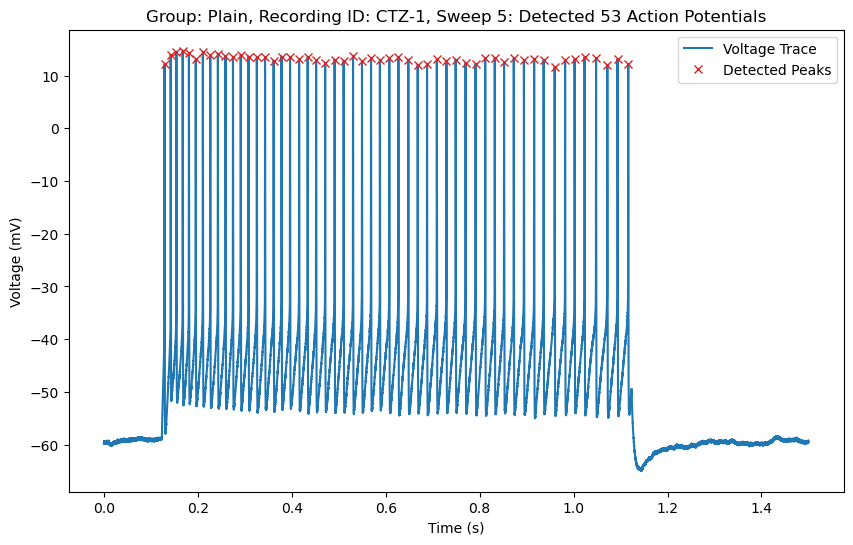

{'group': 'Plain', 'recording_id': 'CTZ-1', 'label': 'Before', 'sweep_number': 5, 'action_potential_count': 53, 'peak_indices': array([ 1291,  1422,  1544, ..., 10718, 10935, 11163])}


In [68]:
result = processor.detect_action_potentials(
    group="Plain",
    recording_id="CTZ-1",
    label="Before",
    sweep_number=5,
    height=0.1,  # Adjust based on signal properties
    prominence=0.05,
    distance=50
)

print(result)

In [78]:
output_dir = "/Users/ecrespo/Desktop/BLADe_patch_data_output_standard"
processor.create_group_pdf_with_peaks(
    output_dir=output_dir,
    height=0.1,  # Adjust based on signal properties
    prominence=0.05,
    distance=50
)

Saved wide PDF for group 'L + ACR2-CTZ' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_standard/L + ACR2-CTZ_wide.pdf
Saved wide PDF for group 'L + CS-CTZ' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_standard/L + CS-CTZ_wide.pdf
Saved wide PDF for group 'L + CS-Veh' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_standard/L + CS-Veh_wide.pdf
Skipping incomplete pair for Recording ID: CTZ-3 in group L + DUD-CTZ
Saved wide PDF for group 'L + DUD-CTZ' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_standard/L + DUD-CTZ_wide.pdf
Saved wide PDF for group 'L Only' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_standard/L Only_wide.pdf
Saved wide PDF for group 'Plain' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_standard/Plain_wide.pdf


In [79]:
output_dir = "/Users/ecrespo/Desktop/BLADe_patch_data_output_optimized"
processor.create_group_pdf_with_peaks(
    output_dir=output_dir,
    height=0.08,  # Adjust based on signal properties
    prominence=0.1,
    distance=30, 
    width=0.01
)

Saved wide PDF for group 'L + ACR2-CTZ' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/L + ACR2-CTZ_wide.pdf
Saved wide PDF for group 'L + CS-CTZ' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/L + CS-CTZ_wide.pdf
Saved wide PDF for group 'L + CS-Veh' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/L + CS-Veh_wide.pdf
Skipping incomplete pair for Recording ID: CTZ-3 in group L + DUD-CTZ
Saved wide PDF for group 'L + DUD-CTZ' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/L + DUD-CTZ_wide.pdf
Saved wide PDF for group 'L Only' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/L Only_wide.pdf
Saved wide PDF for group 'Plain' to: /Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/Plain_wide.pdf


In [80]:
processor.process_peaks(
    height=0.08,  # Adjust based on signal properties
    prominence=0.1,
    distance=30, 
    width=0.01,
    save_csv_path='/Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/peak_data.csv'
)

Processed peaks for 1190 sweeps.
Saved peak data to /Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/peak_data.csv.


In [83]:
processor.import_csv_and_plot_mean_peaks(
    csv_path='/Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/peak_data_modified.csv',
    output_pdf_path='/Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/peak_data_modified_plot.pdf'
)

Saved mean AP count plots to: /Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/peak_data_modified_plot.pdf


In [87]:
processor.import_csv_and_plot_mean_peaks_lineplot(csv_path='/Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/peak_data_modified.csv',
    output_pdf_path='/Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/peak_data_modified_lineplot.pdf')

Saved line plots for mean AP counts to: /Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/peak_data_modified_lineplot.pdf


In [95]:
processor.import_csv_and_plot_mean_peaks_with_error_bars(csv_path='/Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/peak_data_modified.csv',
    output_pdf_path='/Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/peak_data_modified_lineplotwitherrorbars.pdf')

Saved error bar plots for mean AP counts to: /Users/ecrespo/Desktop/BLADe_patch_data_output_optimized/peak_data_modified_lineplotwitherrorbars.pdf
